In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier , export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
import os
import s3fs
import pyarrow.parquet as pq

pd.set_option('max_rows',100)
pd.set_option('max_columns',None)

# os.chdir('/../mnt')

def train_tree(mdt, y_var, params_dict):
    """
    Trains the tree to produce the profile
    :param params_dict:
    :return:
    """
    # Parameters
    predictive_vars = params_dict['predictive_cols']
    min_percent_leaf = params_dict['min_percent_leaf']

    mdt = mdt[predictive_vars]

    reg_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3,min_samples_leaf=int(mdt.shape[0] * min_percent_leaf))

    reg_tree.fit(mdt, y_var)

    return reg_tree


def produce_dot_file(trained_tree, file_name):
    full_path = params_dict['output_path'] + file_name
    export_graphviz(trained_tree, feature_names=params_dict['predictive_cols'],
                    out_file=full_path,
                    filled=True, proportion=True,
                    rounded=True)


def main(mdt, y_var):
    name = 'tree_'+params_dict['segment_name']+'_V0.dot'
    my_tree = train_tree(mdt, y_var, params_dict)
    produce_dot_file(my_tree, name)
    print('Tree produced')
    return my_tree



In [2]:
# Definir parámetros
params_dict = {'min_percent_leaf': 0.05,
               'input_path':'s3://adl-refined-dev-popular/parquet/TC_adquisicion/total_tdc_perf',
              'output_path':'/mnt/work/CU_adquisicionTC/Notebooks/creacion modelo/resultados_arbolV0/',
              'segment_name':'perfilados'}

In [3]:
fs = s3fs.S3FileSystem()

# Leyendo base
input = params_dict['input_path']
dataset = pq.ParquetDataset(input, filesystem=fs)
table = dataset.read()
mdt = table.to_pandas()

del input, dataset, table

# Definiendo Var Obj'var_final'etivo
y_var = 'venta'


In [4]:
mdt.shape

(27731, 1559)

In [5]:
mdt['venta'].value_counts()

0.0    27660
1.0       71
Name: venta, dtype: int64

In [6]:
mdt['venta'].value_counts(normalize=True)*100

0.0    99.743969
1.0     0.256031
Name: venta, dtype: float64

In [7]:
## Libranza
lib_df = pd.read_parquet("s3://adl-refined-dev-popular/parquet/TC_adquisicion/base_libranzas_201801_201912",engine='pyarrow')

In [8]:
lib_df.columns

Index(['id_cliente', 'num_lib_solicitadas', 'prom_monto_solicitado',
       'prom_monto_aprobado', 'prom_monto_desembolsado', 'prom_monto_novado',
       'min_anos_ult_lib', 'prom_prop_desembolso', 'prom_n_cuotas',
       'prom_valor_cuota', 'prom_tasa', 'prom_dias_procesamiento',
       'max_dias_procesamiento', 'n_novaciones', 'sector_ultlibranza',
       'subsector_ultlibranza', 'tipo_pagaduria_ultlibranza', 'periodo',
       'fecha_lib'],
      dtype='object')

In [9]:
# agregando min_anos_ult_lib
mdt = pd.merge(mdt,lib_df[['id_cliente','fecha_lib','min_anos_ult_lib']], on=['id_cliente','fecha_lib'],how='left')

In [10]:
mdt.shape

(27731, 1560)

In [11]:
mdt.columns

Index(['id_cliente', 'fecha_tx_pav', 'fecha_tx_act', 'fecha_pasivo',
       'fecha_lib', 'fecha_activo', 'fecha_buro', 'data_camp', 'mes_campaña',
       'venta',
       ...
       'prom_mov_ult_4meses_ahr', 'prom_mov_ult_6meses_ahr', 'mode_dia_ahr',
       'estado_cta_actual_ahr', 'tipo_transaccion_ahr', 'sum_tx_linea_ahr',
       'sum_tx_nolinea_ahr', 'fecha_ult_tx_ahr', 'dias_desde_ult_tx_ahr',
       'min_anos_ult_lib'],
      dtype='object', length=1560)

In [12]:
#np.random.seed(seed=4321) # Semilla
## Muestra del 50%
#Se generan numeros aleatorios entre 0 y 1
#mdt['ran']=np.random.random(size=mdt.shape[0])

#Se seleccion train : 50% 
mdt_v0=mdt.copy()

# quitando otras variables VO
mdt_v0.drop(columns=['var_final','mes_campaña','30first_use', 'fecha_activo', 'fecha_buro', 'fecha_data', 'fecha_envio',
                     'tipo_campana', 'periodo','cedulaenc','tipo_cliente','tipo_id','derogatorio',
                    'fecha_real','fecha_mas_antigua_apertura','timestamp','lag_t_6_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_tot_SMLV', 
                     'lag_t_1_amortizacion_prom_LB', 'lag_t_6_amortizacion_prom_LB', 'lag_t_1_amortizacion_prom_tot', 
                     'lag_t_6_amortizacion_prom_tot', 'lag_t_6_saldo_tot_LB_SMLV', 'lag_t_1_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_tot_SMLV', 'lag_t_6_cupo_tot_LB_SMLV', 'lag_t_1_cupo_tot_tot_SMLV', 'lag_t_6_cupo_tot_tot_SMLV'], inplace = True)



In [13]:
mdt_v0.shape

(27731, 1530)

In [14]:
## Vars modelo:

top_vars = [
'acep_oferta_prev',
'num_act_utl_meses',
'num_camp_ult_meses',
'num_meses_ult_camp',
'num_no_aceptado',
'num_lib_solicitadas',
'prom_monto_solicitado',
'prom_monto_aprobado',
'prom_monto_desembolsado',
'prom_monto_novado',
'prom_prop_desembolso',
'prom_n_cuotas',
'prom_valor_cuota',
'prom_tasa',
'prom_dias_procesamiento',
'max_dias_procesamiento',
'n_novaciones',
'min_anos_ult_lib',
'sector_ultlibranza',
'subsector_ultlibranza',
'tipo_pagaduria_ultlibranza',
'pasv_num_ctas_vig_tot',
'pasv_num_ctas_vig_cc',
'pasv_num_ctas_vig_ca',
'pasv_num_ctas_vig_cdt',
'pasv_dias_desde_ultima_trans',
'pasv_antig_total',
'pasv_num_meses_ult_apertura',
'pasv_saldo_tot_fin_mes_smlv',
'pasv_saldo_cc_fin_mes_smlv',
'pasv_saldo_ca_fin_mes_smlv',
'pasv_saldo_cdt_fin_mes_smlv',
'pasv_saldo_min_fin_mes_smlv',
'pasv_saldo_min_cc_fin_mes_smlv',
'pasv_saldo_min_ca_fin_mes_smlv',
'pasv_saldo_min_cdt_fin_mes_smlv',
'pasv_saldo_max_fin_mes_smlv',
'pasv_saldo_max_cc_fin_mes_smlv',
'pasv_saldo_max_ca_fin_mes_smlv',
'pasv_saldo_max_cdt_fin_mes_smlv',
'pasv_saldo_total_1mes_atras',
'pasv_saldo_cc_1mes_atras',
'pasv_saldo_ca_1mes_atras',
'pasv_saldo_cdt_1mes_atras',
'pasv_saldo_total_3mes_atras',
'pasv_saldo_cc_3mes_atras',
'pasv_saldo_ca_3mes_atras',
'pasv_saldo_cdt_3mes_atras',
'pasv_saldo_total_6mes_atras',
'pasv_saldo_cc_6mes_atras',
'pasv_saldo_ca_6mes_atras',
'pasv_saldo_cdt_6mes_atras',
'num_tx_ult_1mes_pasv',
'num_tx_ult_2meses_pasv',
'num_tx_ult_3meses_pasv',
'num_tx_ult_4meses_pasv',
'num_tx_ult_6meses_pasv',
'prom_tx_ult_1meses_pasv',
'prom_tx_ult_2meses_pasv',
'prom_tx_ult_3meses_pasv',
'prom_tx_ult_4meses_pasv',
'prom_tx_ult_6meses_pasv',
'mode_dia_pasv',
'estado_cta_actual_pasv',
'tipo_transaccion',
'sum_tx_linea_pasv',
'sum_tx_nolinea_pasv',
'fecha_ult_tx_pasv',
'dias_desde_ult_tx_pasv',
'num_tx_ult_1mes_cte',
'num_tx_ult_2meses_cte',
'num_tx_ult_3meses_cte',
'num_tx_ult_4meses_cte',
'num_tx_ult_6meses_cte',
'prom_tx_ult_1meses_cte',
'prom_tx_ult_2meses_cte',
'prom_tx_ult_3meses_cte',
'prom_tx_ult_4meses_cte',
'prom_tx_ult_6meses_cte',
'mode_dia_cte',
'estado_cta_actual_cte',
'tipo_transaccion_cte',
'sum_tx_linea_cte',
'fecha_ult_tx_cte',
'dias_desde_ult_tx_cte',
'num_tx_ult_1mes_cdt',
'num_tx_ult_2meses_cdt',
'num_tx_ult_3meses_cdt',
'num_tx_ult_4meses_cdt',
'num_tx_ult_6meses_cdt',
'prom_tx_ult_1meses_cdt',
'prom_tx_ult_2meses_cdt',
'prom_tx_ult_3meses_cdt',
'prom_tx_ult_4meses_cdt',
'prom_tx_ult_6meses_cdt',
'mode_dia_cdt',
'estado_cta_actual_cdt',
'tipo_transaccion_cdt',
'sum_tx_nolinea_cdt',
'fecha_ult_tx_cdt',
'dias_desde_ult_tx_cdt',
'num_tx_ult_1mes_ahr',
'num_tx_ult_2meses_ahr',
'num_tx_ult_3meses_ahr',
'num_tx_ult_4meses_ahr',
'num_tx_ult_6meses_ahr',
'prom_tx_ult_1meses_ahr',
'prom_tx_ult_2meses_ahr',
'prom_tx_ult_3meses_ahr',
'prom_tx_ult_4meses_ahr',
'prom_tx_ult_6meses_ahr',
'mode_dia_ahr',
'estado_cta_actual_ahr',
'tipo_transaccion_ahr',
'sum_tx_linea_ahr',
'sum_tx_nolinea_ahr',
'fecha_ult_tx_ahr',
'dias_desde_ult_tx_ahr'
]

In [15]:
mdt_v0.shape

(27731, 1530)

In [16]:
mdt_v0 = mdt_v0[['id_cliente','data_camp','venta']+top_vars]

In [17]:
mdt_v0['num_nulos'] = mdt_v0.apply(lambda row: (row.isnull()).sum(), axis=1)
mdt_v0['num_nulos'].describe()

count    27731.000000
mean        68.928275
std         25.890743
min          0.000000
25%         55.000000
50%         59.000000
75%         86.000000
max        118.000000
Name: num_nulos, dtype: float64

In [18]:
# print(mdt_v0[mdt_v0['num_nulos']<90].shape)
# print(mdt['venta'].value_counts())
# print(mdt['venta'].value_counts(normalize=True))
# print(mdt_v0.loc[mdt_v0['num_nulos']<90,'venta'].value_counts())
# print(mdt_v0.loc[mdt_v0['num_nulos']<90,'venta'].value_counts(normalize=True))
mdt_v0 = mdt_v0[mdt_v0['num_nulos']<90]

In [19]:
mdt_v0.shape

(21021, 122)

In [20]:
mdt_v0.head()

,id_cliente,data_camp,venta,acep_oferta_prev,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_camp,num_no_aceptado,num_lib_solicitadas,prom_monto_solicitado,prom_monto_aprobado,prom_monto_desembolsado,prom_monto_novado,prom_prop_desembolso,prom_n_cuotas,prom_valor_cuota,prom_tasa,prom_dias_procesamiento,max_dias_procesamiento,n_novaciones,min_anos_ult_lib,sector_ultlibranza,subsector_ultlibranza,tipo_pagaduria_ultlibranza,pasv_num_ctas_vig_tot,pasv_num_ctas_vig_cc,pasv_num_ctas_vig_ca,pasv_num_ctas_vig_cdt,pasv_dias_desde_ultima_trans,pasv_antig_total,pasv_num_meses_ult_apertura,pasv_saldo_tot_fin_mes_smlv,pasv_saldo_cc_fin_mes_smlv,pasv_saldo_ca_fin_mes_smlv,pasv_saldo_cdt_fin_mes_smlv,pasv_saldo_min_fin_mes_smlv,pasv_saldo_min_cc_fin_mes_smlv,pasv_saldo_min_ca_fin_mes_smlv,pasv_saldo_min_cdt_fin_mes_smlv,pasv_saldo_max_fin_mes_smlv,pasv_saldo_max_cc_fin_mes_smlv,pasv_saldo_max_ca_fin_mes_smlv,pasv_saldo_max_cdt_fin_mes_smlv,pasv_saldo_total_1mes_atras,pasv_saldo_cc_1mes_atras,pasv_saldo_ca_1mes_atras,pasv_saldo_cdt_1mes_atras,pasv_saldo_total_3mes_atras,pasv_saldo_cc_3mes_atras,pasv_saldo_ca_3mes_atras,pasv_saldo_cdt_3mes_atras,pasv_saldo_total_6mes_atras,pasv_saldo_cc_6mes_atras,pasv_saldo_ca_6mes_atras,pasv_saldo_cdt_6mes_atras,num_tx_ult_1mes_pasv,num_tx_ult_2meses_pasv,num_tx_ult_3meses_pasv,num_tx_ult_4meses_pasv,num_tx_ult_6meses_pasv,prom_tx_ult_1meses_pasv,prom_tx_ult_2meses_pasv,prom_tx_ult_3meses_pasv,prom_tx_ult_4meses_pasv,prom_tx_ult_6meses_pasv,mode_dia_pasv,estado_cta_actual_pasv,tipo_transaccion,sum_tx_linea_pasv,sum_tx_nolinea_pasv,fecha_ult_tx_pasv,dias_desde_ult_tx_pasv,num_tx_ult_1mes_cte,num_tx_ult_2meses_cte,num_tx_ult_3meses_cte,num_tx_ult_4meses_cte,num_tx_ult_6meses_cte,prom_tx_ult_1meses_cte,prom_tx_ult_2meses_cte,prom_tx_ult_3meses_cte,prom_tx_ult_4meses_cte,prom_tx_ult_6meses_cte,mode_dia_cte,estado_cta_actual_cte,tipo_transaccion_cte,sum_tx_linea_cte,fecha_ult_tx_cte,dias_desde_ult_tx_cte,num_tx_ult_1mes_cdt,num_tx_ult_2meses_cdt,num_tx_ult_3meses_cdt,num_tx_ult_4meses_cdt,num_tx_ult_6meses_cdt,prom_tx_ult_1meses_cdt,prom_tx_ult_2meses_cdt,prom_tx_ult_3meses_cdt,prom_tx_ult_4meses_cdt,prom_tx_ult_6meses_cdt,mode_dia_cdt,estado_cta_actual_cdt,tipo_transaccion_cdt,sum_tx_nolinea_cdt,fecha_ult_tx_cdt,dias_desde_ult_tx_cdt,num_tx_ult_1mes_ahr,num_tx_ult_2meses_ahr,num_tx_ult_3meses_ahr,num_tx_ult_4meses_ahr,num_tx_ult_6meses_ahr,prom_tx_ult_1meses_ahr,prom_tx_ult_2meses_ahr,prom_tx_ult_3meses_ahr,prom_tx_ult_4meses_ahr,prom_tx_ult_6meses_ahr,mode_dia_ahr,estado_cta_actual_ahr,tipo_transaccion_ahr,sum_tx_linea_ahr,sum_tx_nolinea_ahr,fecha_ult_tx_ahr,dias_desde_ult_tx_ahr,num_nulos
1,103552310668742802,201905,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,1.0,0.0,1.0,0.0,12.0,57.566667,57.566667,0.002337,NaN,0.002337,NaN,0.002337,NaN,0.002337,NaN,0.002337,NaN,0.002337,NaN,0.003644,0.0,0.003644,0.000000,0.018616,0.0,0.018616,0.000000,0.010195,0.0,0.010195,0.000000,2.000000,6.000000,38.000000,38.000000,38.000000,2.000000,3.000000,12.666667,9.500000,6.333333,Thursday,1,2,1.0,1.0,2019-04-25,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,None,NaN,2.000000,6.000000,38.000000,38.000000,38.000000,2.000000,3.000000,12.666667,9.500000,6.333333,Thursday,1,1,1.0,1.0,2019-04-25,5.0,59
2,139955260696468901,201910,0.0,NaN,NaN,NaN,NaN,NaN,2.0,15750000.0,15750000.0,9233777.0,5455780.0,0.611499,72.0,326726.0,14.34,1.0,1.0,1.0,7.124832,ORDEN NACIONAL,Policia Nacional,NACIONAL CENTRALIZADA,1.0,0.0,1.0,0.0,5.0,128.933333,128.933333,1.087069,NaN,1.087069,NaN,1.087069,NaN,1.087069,NaN,1.087069,NaN,1.087069,NaN,1.087069,0.0,1.087069,0.000000,1.270542,0.0,1.270542,0.000000,0.735594,0.0,0.735594,0.000000,41.578947,82.105263,109.184211,122.657895,130.605263,41.578947,41.052632,36.394737,30.664474,21.767544,Monday,1,2,10.0,28.0,2019-09-30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,N

In [21]:
mdt['venta'].value_counts(normalize=True)*100

0.0    99.743969
1.0     0.256031
Name: venta, dtype: float64

In [22]:
mdt_v0['venta'].value_counts(normalize=True)*100

0.0    99.709814
1.0     0.290186
Name: venta, dtype: float64

In [23]:
mdt_v0.set_index(['id_cliente','data_camp'], inplace=True)

In [24]:
cat_cols = list(mdt_v0.dtypes[mdt_v0.dtypes=='object'].index)
cat_cols

['sector_ultlibranza',
 'subsector_ultlibranza',
 'tipo_pagaduria_ultlibranza',
 'mode_dia_pasv',
 'estado_cta_actual_pasv',
 'tipo_transaccion',
 'fecha_ult_tx_pasv',
 'mode_dia_cte',
 'estado_cta_actual_cte',
 'tipo_transaccion_cte',
 'fecha_ult_tx_cte',
 'mode_dia_cdt',
 'estado_cta_actual_cdt',
 'tipo_transaccion_cdt',
 'fecha_ult_tx_cdt',
 'mode_dia_ahr',
 'estado_cta_actual_ahr',
 'tipo_transaccion_ahr',
 'fecha_ult_tx_ahr']

In [25]:
# feature engineering

# mdt_v0['ciudad_de_expedicion_cat'] = (mdt_v0['ciudad_de_expedicion'] == 'BOGOTA D.C.').astype('int')
# mdt_v0['genero_cat'] = (mdt_v0['genero'] == 'F').astype('int')
# mdt_v0['peor_califi_trim_1_endeud_cat'] = (mdt_v0['peor_califi_trim_1_endeud'] == 'mantiene').astype('int')
# mdt_v0['peor_calif_trim_2_endeud_cat'] = (mdt_v0['peor_calif_trim_2_endeud'] == 'mantiene').astype('int')
# mdt_v0['rango_aproximado_edad_cat'] = (mdt_v0['rango_aproximado_edad'] == 'mantiene').astype('int')
# mdt_v0['marca_derogatorio_cat'] = (mdt_v0['marca_derogatorio'] == 'aprobado').astype('int')
# mdt_v0['tdc_altura_maxima_de_mora_was_is_cat'] = (mdt_v0['tdc_altura_maxima_de_mora_was_is'] == 'mantiene').astype('int')
# mdt_v0['cartera_banca_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_banca_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
# mdt_v0['cartera_coope_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_coope_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
# mdt_v0['cartera_hipote_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_hipote_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
# mdt_v0['moramax_mercado_was_is_cat'] = (mdt_v0['moramax_mercado_was_is'] == 'mantiene').astype('int')
# mdt_v0['was_is_LB_cat'] = (mdt_v0['was_is_LB'] == 'mantiene').astype('int')
# mdt_v0['was_is_TC_cat'] = (mdt_v0['was_is_TC'] == 'mantiene').astype('int')
# mdt_v0['was_is_NV_cat'] = (mdt_v0['was_is_NV'] == 'mantiene').astype('int')
# mdt_v0['was_is_CH_cat'] = (mdt_v0['was_is_CH'] == 'mantiene').astype('int')
# mdt_v0['was_is_CE_cat'] = (mdt_v0['was_is_CE'] == 'mantiene').astype('int')
# mdt_v0['was_is_LE_cat'] = (mdt_v0['was_is_LE'] == 'mantiene').astype('int')
# mdt_v0['was_is_ME_cat'] = (mdt_v0['was_is_ME'] == 'mantiene').astype('int')
# mdt_v0['was_is_SO_cat'] = (mdt_v0['was_is_SO'] == 'mantiene').astype('int')
# mdt_v0['was_is_CC_cat'] = (mdt_v0['was_is_CC'] == 'mantiene').astype('int')
# mdt_v0['was_is_TC_X_cat'] = (mdt_v0['was_is_TC_X'] == 'mantiene').astype('int')
# mdt_v0['was_is_TC_T_cat'] = (mdt_v0['was_is_TC_T'] == 'mantiene').astype('int')
# mdt_v0['was_is_tot_cat'] = (mdt_v0['was_is_tot'] == 'mantiene').astype('int')


mdt_v0['tiene_sector_libranza'] = (mdt_v0['sector_ultlibranza'].notnull()).astype('int')
mdt_v0['tiene_subsector_libranza'] = (mdt_v0['subsector_ultlibranza'] == 'mantiene').astype('int')
mdt_v0['tiene_pagaduria_libranza'] = (mdt_v0['tipo_pagaduria_ultlibranza'] == 'mantiene').astype('int')
mdt_v0['estado_cta_actual_pasv1'] = (mdt_v0['estado_cta_actual_pasv'] == '1').astype('int')

mdt_v0['tipo_transaccion_pasv2'] = (mdt_v0['tipo_transaccion'] == '2').astype('int')
mdt_v0['estado_cta_actual_pasv1'] = (mdt_v0['estado_cta_actual_pasv'] == '1').astype('int')

mdt_v0['tipo_transaccion_cte2'] = (mdt_v0['tipo_transaccion_cte'] == '2').astype('int')
mdt_v0['estado_cta_actual_cte1'] = (mdt_v0['estado_cta_actual_cte'] == '1').astype('int')

mdt_v0['tipo_transaccion_ahr2'] = (mdt_v0['tipo_transaccion_ahr'] == '2').astype('int')
mdt_v0['estado_cta_actual_ahr1'] = (mdt_v0['estado_cta_actual_ahr'] == '1').astype('int')

mdt_v0['tipo_transaccion_pasv2'] = (mdt_v0['tipo_transaccion'] == '2').astype('int')
mdt_v0['estado_cta_actual_pasv1'] = (mdt_v0['estado_cta_actual_pasv'] == '1').astype('int')



In [26]:
## Categorizing variables
mdt_v0 = mdt_v0.join(pd.get_dummies(mdt_v0[['mode_dia_pasv',
'mode_dia_cte',
'mode_dia_cdt',
'mode_dia_ahr']]), how='left')

In [27]:
mdt_v0.reset_index(inplace=True)

In [28]:
mdt_v0.drop(columns=['data_camp']+cat_cols, inplace = True)

In [29]:
mdt_v0.set_index(['id_cliente'], inplace=True)

In [30]:
mdt_v0.columns

Index(['venta', 'acep_oferta_prev', 'num_act_utl_meses', 'num_camp_ult_meses',
       'num_meses_ult_camp', 'num_no_aceptado', 'num_lib_solicitadas',
       'prom_monto_solicitado', 'prom_monto_aprobado',
       'prom_monto_desembolsado',
       ...
       'mode_dia_cdt_Thursday', 'mode_dia_cdt_Tuesday',
       'mode_dia_cdt_Wednesday', 'mode_dia_ahr_Friday', 'mode_dia_ahr_Monday',
       'mode_dia_ahr_Saturday', 'mode_dia_ahr_Sunday', 'mode_dia_ahr_Thursday',
       'mode_dia_ahr_Tuesday', 'mode_dia_ahr_Wednesday'],
      dtype='object', length=138)

In [31]:
mdt_v0.describe()

,venta,acep_oferta_prev,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_camp,num_no_aceptado,num_lib_solicitadas,prom_monto_solicitado,prom_monto_aprobado,prom_monto_desembolsado,prom_monto_novado,prom_prop_desembolso,prom_n_cuotas,prom_valor_cuota,prom_tasa,prom_dias_procesamiento,max_dias_procesamiento,n_novaciones,min_anos_ult_lib,pasv_num_ctas_vig_tot,pasv_num_ctas_vig_cc,pasv_num_ctas_vig_ca,pasv_num_ctas_vig_cdt,pasv_dias_desde_ultima_trans,pasv_antig_total,pasv_num_meses_ult_apertura,pasv_saldo_tot_fin_mes_smlv,pasv_saldo_cc_fin_mes_smlv,pasv_saldo_ca_fin_mes_smlv,pasv_saldo_cdt_fin_mes_smlv,pasv_saldo_min_fin_mes_smlv,pasv_saldo_min_cc_fin_mes_smlv,pasv_saldo_min_ca_fin_mes_smlv,pasv_saldo_min_cdt_fin_mes_smlv,pasv_saldo_max_fin_mes_smlv,pasv_saldo_max_cc_fin_mes_smlv,pasv_saldo_max_ca_fin_mes_smlv,pasv_saldo_max_cdt_fin_mes_smlv,pasv_saldo_total_1mes_atras,pasv_saldo_cc_1mes_atras,pasv_saldo_ca_1mes_atras,pasv_saldo_cdt_1mes_atras,pasv_saldo_total_3mes_atras,pasv_saldo_cc_3mes_atras,pasv_saldo_ca_3mes_atras,pasv_saldo_cdt_3mes_atras,pasv_saldo_total_6mes_atras,pasv_saldo_cc_6mes_atras,pasv_saldo_ca_6mes_atras,pasv_saldo_cdt_6mes_atras,num_tx_ult_1mes_pasv,num_tx_ult_2meses_pasv,num_tx_ult_3meses_pasv,num_tx_ult_4meses_pasv,num_tx_ult_6meses_pasv,prom_tx_ult_1meses_pasv,prom_tx_ult_2meses_pasv,prom_tx_ult_3meses_pasv,prom_tx_ult_4meses_pasv,prom_tx_ult_6meses_pasv,sum_tx_linea_pasv,sum_tx_nolinea_pasv,dias_desde_ult_tx_pasv,num_tx_ult_1mes_cte,num_tx_ult_2meses_cte,num_tx_ult_3meses_cte,num_tx_ult_4meses_cte,num_tx_ult_6meses_cte,prom_tx_ult_1meses_cte,prom_tx_ult_2meses_cte,prom_tx_ult_3meses_cte,prom_tx_ult_4meses_cte,prom_tx_ult_6meses_cte,sum_tx_linea_cte,dias_desde_ult_tx_cte,num_tx_ult_1mes_cdt,num_tx_ult_2meses_cdt,num_tx_ult_3meses_cdt,num_tx_ult_4meses_cdt,num_tx_ult_6meses_cdt,prom_tx_ult_1meses_cdt,prom_tx_ult_2meses_cdt,prom_tx_ult_3meses_cdt,prom_tx_ult_4meses_cdt,prom_tx_ult_6meses_cdt,sum_tx_nolinea_cdt,dias_desde_ult_tx_cdt,num_tx_ult_1mes_ahr,num_tx_ult_2meses_ahr,num_tx_ult_3meses_ahr,num_tx_ult_4meses_ahr,num_tx_ult_6meses_ahr,prom_tx_ult_1meses_ahr,prom_tx_ult_2meses_ahr,prom_tx_ult_3meses_ahr,prom_tx_ult_4meses_ahr,prom_tx_ult_6meses_ahr,sum_tx_linea_ahr,sum_tx_nolinea_ahr,dias_desde_ult_tx_ahr,num_nulos,tiene_sector_libranza,tiene_subsector_libranza,tiene_pagaduria_libranza,estado_cta_actual_pasv1,tipo_transaccion_pasv2,tipo_transaccion_cte2,estado_cta_actual_cte1,tipo_transaccion_ahr2,estado_cta_actual_ahr1,mode_dia_pasv_Friday,mode_dia_pasv_Monday,mode_dia_pasv_Saturday,mode_dia_pasv_Sunday,mode_dia_pasv_Thursday,mode_dia_pasv_Tuesday,mode_dia_pasv_Wednesday,mode_dia_cte_Friday,mode_dia_cte_Monday,mode_dia_cte_Saturday,mode_dia_cte_Sunday,mode_dia_cte_Thursday,mode_dia_cte_Tuesday,mode_dia_cte_Wednesday,mode_dia_cdt_Friday,mode_dia_cdt_Monday,mode_dia_cdt_Saturday,mode_dia_cdt_Sunday,mode_dia_cdt_Thursday,mode_dia_cdt_Tuesday,mode_dia_cdt_Wednesday,mode_dia_ahr_Friday,mode_dia_ahr_Monday,mode_dia_ahr_Saturday,mode_dia_ahr_Sunday,mode_dia_ahr_Thursday,mode_dia_ahr_Tuesday,mode_dia_ahr_Wednesday
count,21021.000000,827.0,827.0,827.000000,827.000000,827.000000,7345.000000,7.345000e+03,7.345000e+03,7.345000e+03,7.345000e+03,7345.000000,7345.000000,7.345000e+03,7345.000000,7345.000000,7345.000000,7345.000000,7345.000000,19930.000000,19930.000000,19930.000000,19930.000000,19918.000000,19930.000000,19930.000000,19930.000000,703.000000,19308.000000,608.000000,19930.000000,703.000000,19308.000000,608.000000,19930.000000,703.000000,19308.000000,608.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,19930.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,20168.000000,18626.000000,18744.000000,20168.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,639.000000,675.000000

In [32]:
np.random.seed(seed=1234) # Semilla

#Se generan numeros aleatorios entre 0 y 1
mdt_v0['ran2']=np.random.random(size=mdt_v0.shape[0])

#Se seleccion train : 50% 
mdt_train=mdt_v0[mdt_v0['ran2']<=0.7]
mdt_test=mdt_v0[mdt_v0['ran2']>0.7]

###
y = mdt_train['venta']
y_test = mdt_test['venta']

mdt_train.drop(columns=['venta','ran2'],inplace=True)
mdt_test.drop(columns=['venta','ran2'],inplace=True)

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
mdt['venta'].value_counts(normalize=True)

0.0    0.99744
1.0    0.00256
Name: venta, dtype: float64

In [34]:
mdt_v0['venta'].value_counts(normalize=True)

0.0    0.997098
1.0    0.002902
Name: venta, dtype: float64

In [35]:
y.value_counts(normalize=True)

0.0    0.997075
1.0    0.002925
Name: venta, dtype: float64

In [36]:
y_test.value_counts(normalize=True)

0.0    0.997152
1.0    0.002848
Name: venta, dtype: float64

In [37]:
cols_modelo = mdt_train.columns
params_dict['predictive_cols'] = cols_modelo

In [38]:
np.random.seed(seed=1234) # Semilla
# Split dataset into training set and test set
X_train, X_val, y_train, y_val = train_test_split(mdt_train, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [39]:
y_train.value_counts(normalize=True)*100

0.0    99.698737
1.0     0.301263
Name: venta, dtype: float64

In [40]:
y_val.value_counts(normalize=True)*100

0.0    99.727953
1.0     0.272047
Name: venta, dtype: float64

In [41]:
y_test.value_counts(normalize=True)*100

0.0    99.71519
1.0     0.28481
Name: venta, dtype: float64

In [42]:
vars_final = list(cols_modelo)
# vars_final = ['acep_oferta_prev', 'num_act_utl_meses', 'num_camp_ult_meses', 'num_meses_ult_camp', 'num_no_aceptado', 
# 'num_lib_solicitadas', 'prom_monto_solicitado', 'prom_monto_aprobado', 'prom_monto_desembolsado', 'prom_monto_novado', 
# 'prom_prop_desembolso', 'prom_n_cuotas', 'prom_valor_cuota', 'prom_tasa', 'prom_dias_procesamiento', 'max_dias_procesamiento', 
# 'n_novaciones', 'pasv_num_ctas_vig_tot', 'pasv_num_ctas_vig_cc', 'pasv_num_ctas_vig_ca', 'pasv_num_ctas_vig_cdt', 
# 'pasv_dias_desde_ultima_trans', 'pasv_antig_total', 'pasv_num_meses_ult_apertura', 'pasv_saldo_tot_fin_mes_smlv', 
# 'pasv_saldo_cc_fin_mes_smlv', 'pasv_saldo_ca_fin_mes_smlv', 'pasv_saldo_cdt_fin_mes_smlv', 'pasv_saldo_min_fin_mes_smlv', 
# 'pasv_saldo_min_cc_fin_mes_smlv', 'pasv_saldo_min_ca_fin_mes_smlv', 'pasv_saldo_min_cdt_fin_mes_smlv', 
# 'pasv_saldo_max_fin_mes_smlv', 'pasv_saldo_max_cc_fin_mes_smlv', 'pasv_saldo_max_ca_fin_mes_smlv', 
# 'pasv_saldo_max_cdt_fin_mes_smlv', 'pasv_saldo_total_1mes_atras', 'pasv_saldo_cc_1mes_atras', 'pasv_saldo_ca_1mes_atras', 
# 'pasv_saldo_cdt_1mes_atras', 'pasv_saldo_total_3mes_atras', 'pasv_saldo_cc_3mes_atras', 'pasv_saldo_ca_3mes_atras', 
# 'pasv_saldo_cdt_3mes_atras', 'pasv_saldo_total_6mes_atras', 'pasv_saldo_cc_6mes_atras', 'pasv_saldo_ca_6mes_atras', 
# 'pasv_saldo_cdt_6mes_atras', 'tiene_sector_libranza', 'tiene_subsector_libranza', 'tiene_pagaduria_libranza']

### Modelo V0 1200 variables

In [43]:
import shap
import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Se ajusta el modelo con las mejores variables best_20_v3
#'multi:softmax'
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              seed = 1,  
                              max_depth = 5, 
                              colsample_bytree = 0.8,
                              learning_rate = 0.08,
                              gamma=0.2,
                              scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int),
                              n_estimators=300, min_child_weight = 5)

xgb_model.fit(X_train[vars_final], y_train, 
              eval_set = [(X_train[vars_final], y_train), (X_val[vars_final], y_val)],
              early_stopping_rounds=100)

[0]	validation_0-error:0.238484	validation_1-error:0.244162
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.14519	validation_1-error:0.148946
[2]	validation_0-error:0.135957	validation_1-error:0.142145
[3]	validation_0-error:0.158601	validation_1-error:0.163002
[4]	validation_0-error:0.155005	validation_1-error:0.156881
[5]	validation_0-error:0.146356	validation_1-error:0.149853
[6]	validation_0-error:0.13897	validation_1-error:0.145319
[7]	validation_0-error:0.134597	validation_1-error:0.141691
[8]	validation_0-error:0.134694	validation_1-error:0.138744
[9]	validation_0-error:0.13139	validation_1-error:0.138971
[10]	validation_0-error:0.105831	validation_1-error:0.120381
[11]	validation_0-error:0.086492	validation_1-error:0.102471
[12]	validation_0-error:0.090962	validation_1-error:0.104058
[13]	validation_0-error:0.089407	validation_1-error:0.1013

[132]	validation_0-error:0.000194	validation_1-error:0.005668
[133]	validation_0-error:0.000194	validation_1-error:0.005214
[134]	validation_0-error:9.7e-05	validation_1-error:0.004988
[135]	validation_0-error:9.7e-05	validation_1-error:0.004761
[136]	validation_0-error:9.7e-05	validation_1-error:0.004534
[137]	validation_0-error:9.7e-05	validation_1-error:0.004761
[138]	validation_0-error:9.7e-05	validation_1-error:0.004534
[139]	validation_0-error:0	validation_1-error:0.004307
[140]	validation_0-error:0	validation_1-error:0.004307
[141]	validation_0-error:0	validation_1-error:0.004307
[142]	validation_0-error:0	validation_1-error:0.004534
[143]	validation_0-error:0	validation_1-error:0.004307
[144]	validation_0-error:0	validation_1-error:0.004307
[145]	validation_0-error:0	validation_1-error:0.004307
[146]	validation_0-error:0	validation_1-error:0.004307
[147]	validation_0-error:0	validation_1-error:0.004307
[148]	validation_0-error:0	validation_1-error:0.004307
[149]	validation_0-er

[281]	validation_0-error:0	validation_1-error:0.003174
[282]	validation_0-error:0	validation_1-error:0.003174
[283]	validation_0-error:0	validation_1-error:0.003174
[284]	validation_0-error:0	validation_1-error:0.003174
[285]	validation_0-error:0	validation_1-error:0.003174
[286]	validation_0-error:0	validation_1-error:0.003174
[287]	validation_0-error:0	validation_1-error:0.003174
[288]	validation_0-error:0	validation_1-error:0.003174
[289]	validation_0-error:0	validation_1-error:0.003174
[290]	validation_0-error:0	validation_1-error:0.003174
[291]	validation_0-error:0	validation_1-error:0.003174
[292]	validation_0-error:0	validation_1-error:0.003174
[293]	validation_0-error:0	validation_1-error:0.003174
[294]	validation_0-error:0	validation_1-error:0.003174
[295]	validation_0-error:0	validation_1-error:0.003174
[296]	validation_0-error:0	validation_1-error:0.003174
[297]	validation_0-error:0	validation_1-error:0.003174
[298]	validation_0-error:0	validation_1-error:0.003174
[299]	vali

XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.08, max_depth=5,
              min_child_weight=5, n_estimators=300, scale_pos_weight=332,
              seed=1)

In [44]:
# Predecir probabilidades para data test (20%)

probs_test = xgb_model.predict_proba(mdt_test[vars_final])

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])

#AUC
metrics.auc(fpr, tpr)

0.6819704502979653

In [45]:
#Matriz de confusión
predict_test = (probs_test[:, 1] < 0.0028)*1
metrics.confusion_matrix(y_test,predict_test)

array([[1293, 5009],
       [   7,   11]])

In [46]:
#Accuracy
mdt_test['probs'] = probs_test[:, 1]
metrics.accuracy_score(y_test, predict_test)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.20632911392405062

In [47]:
#Recall
metrics.recall_score(y_test, predict_test)

0.6111111111111112

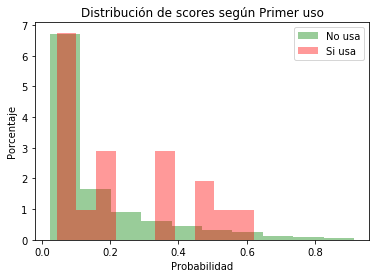

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# Graficar probabilidades según Fraude/No Fraude observado (real)

subset_si = mdt_test[y_test == 1]

subset_no = mdt_test[y_test == 0]

sns.distplot(subset_no[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'No usa', color = 'green')

sns.distplot(subset_si[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'Si usa', color = 'red')

plt.legend(prop = {'size' : 10})
plt.title('Distribución de scores según Primer uso')
plt.xlabel('Probabilidad')
plt.ylabel('Porcentaje')
plt.show()

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


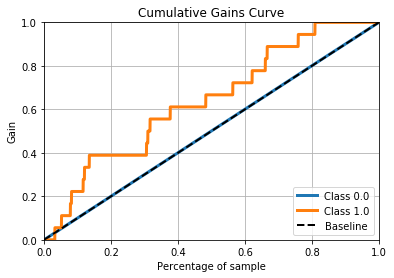

In [180]:
skplt.metrics.plot_cumulative_gain(y_test, probs_test)

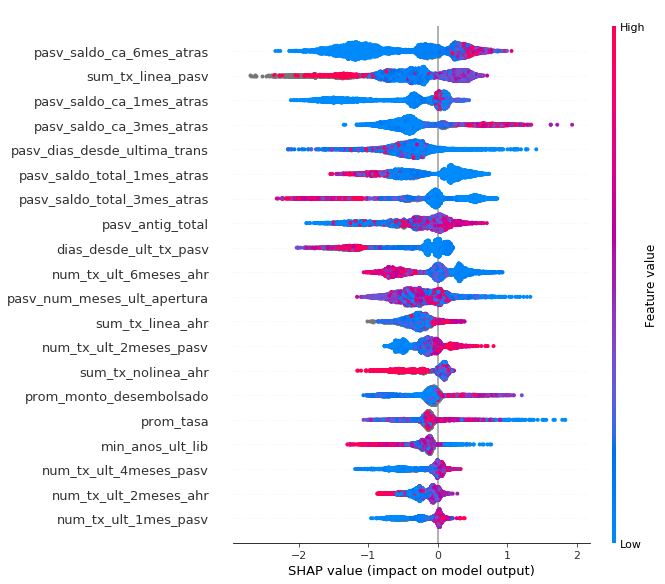

In [181]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(mdt_test[vars_final])
shap.summary_plot(shap_values, mdt_test[vars_final])


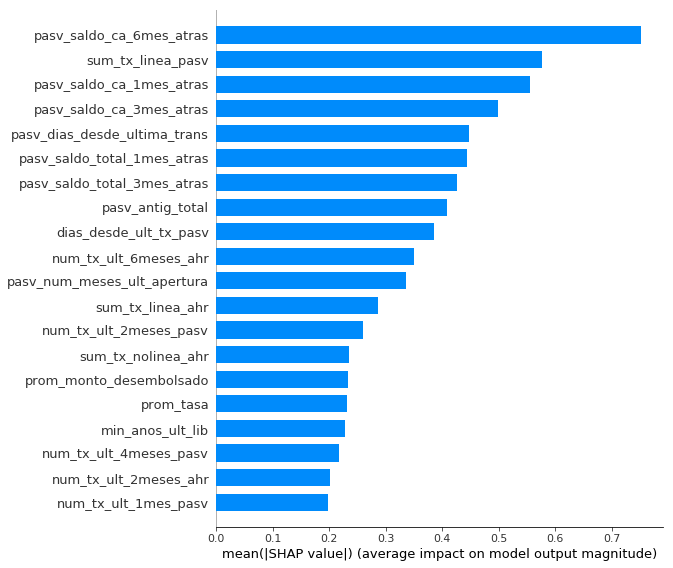

In [182]:
shap.summary_plot(shap_values, mdt_test[vars_final], plot_type = 'bar')

## Grid Search

In [52]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=150, max_depth=5,
 scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int),
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=150, nthread=4,
                                     scale_pos_weight=332, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [53]:
gsearch1.best_score_,gsearch1.best_params_, gsearch1.best_score_

(0.5814900771530829,
 {'max_depth': 7, 'min_child_weight': 1},
 0.5814900771530829)

In [54]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int)
                                                      ,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 8, 'min_child_weight': 2}, 0.5994729937960455)

In [55]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int)
                                                      ,seed=27), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.1}, 0.5824752596951867)

In [56]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=5,
 min_child_weight=5, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int)
                                                      ,seed=27), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.7, 'subsample': 0.6}, 0.6037862173989608)

In [57]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int)
                                                      ,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 4, 'min_child_weight': 5}, 0.5823311880021487)

In [58]:
# #Grid seach on subsample and max_features
# #Choose all predictors except target & IDcols
# #kappa_scorer=make_scorer(cohen_kappa_score)
# scoring = {'Precision': 'precision', 'Recall': 'recall', 'Roc':'roc_auc'}
# param_test1 = {
#     'max_depth': range(4,12,2),
#     'min_child_weight':range(4,8,2),
#     'learning_rate': [0.01, 0.1, 0.2]
# }
# gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,                                       
#                                                       scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int), seed=None), 
#                        param_grid = param_test1, scoring=scoring, n_jobs=4,iid=False, cv=3)
# gsearch1.fit(X_train,y_train)

### Modelo con variables más importantes (top 60)

In [63]:
def train_eval_xgboost(df, features, y, model_num, df_importance):
    
    """
    Función que realiza lo siguiente: 
    1. A partir de Train, realiza un sampling aleatorio 70-30 para Train y Validación
    2. Entrena un modelo XGBoost con la data de Train, usando tanto la data Train como Validación 
        para evaluar (métrica: AUC)
    3. Calcula mean(|SHAP Value|) por variable para base de Train y guarda el valor en df_importance
    4. Calcula auc, accuracy y recall sobre base de Test y guarda los valores en df_metricas, utilizando
    un threshold determinado por el usuario (0.5 por default)
    """
    
    X_train, X_val, y_train, y_val = train_test_split(df[features], y, test_size = .3)
    
    print(model_num)
    
    "Entrenar modelo XGBoost"
    
    xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                              seed = 1,  
                              max_depth = 5, 
                              colsample_bytree = 0.8,
                              learning_rate = 0.08,
                              gamma=0.2,
                              scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int),
                              n_estimators=150, min_child_weight = 3)

    xgb_model.fit(X_train, y_train, 
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  early_stopping_rounds = 500, 
                  verbose = False)
    
    print('Modelo entrenado')
    
    "Calcular y guardar SHAP Values"
    
    shap_values = shap.TreeExplainer(xgb_model).shap_values(df[features])
    shap_feature = np.abs(shap_values).mean(axis = 0)
    
    df_importance['mean_SHAP_'+model_num] = shap_feature
    
    print('SHAP Values guardados')

In [64]:
features_x = cols_modelo
feature_importances = pd.DataFrame({'feature_name' : features_x}, columns = ['feature_name'])

In [65]:
cols_modelo

Index(['acep_oferta_prev', 'num_act_utl_meses', 'num_camp_ult_meses',
       'num_meses_ult_camp', 'num_no_aceptado', 'num_lib_solicitadas',
       'prom_monto_solicitado', 'prom_monto_aprobado',
       'prom_monto_desembolsado', 'prom_monto_novado',
       ...
       'mode_dia_cdt_Thursday', 'mode_dia_cdt_Tuesday',
       'mode_dia_cdt_Wednesday', 'mode_dia_ahr_Friday', 'mode_dia_ahr_Monday',
       'mode_dia_ahr_Saturday', 'mode_dia_ahr_Sunday', 'mode_dia_ahr_Thursday',
       'mode_dia_ahr_Tuesday', 'mode_dia_ahr_Wednesday'],
      dtype='object', length=137)

In [66]:
#Se ejecuta 10 veces la función train_eval_xgboost para la base train (80% de la base total de desarrollo) 
# y se calculan los shap values (para las 10 iteraciones) que quedan guardados en el feature_importances

#for i in range(1, 3):
for i in range(1, 11):
    
    model_num = 'model_'+str(i)
    
    train_eval_xgboost(mdt_train, features_x, y, model_num, feature_importances)

model_1
Modelo entrenado
SHAP Values guardados
model_2
Modelo entrenado
SHAP Values guardados
model_3
Modelo entrenado
SHAP Values guardados
model_4
Modelo entrenado
SHAP Values guardados
model_5
Modelo entrenado
SHAP Values guardados
model_6
Modelo entrenado
SHAP Values guardados
model_7
Modelo entrenado
SHAP Values guardados
model_8
Modelo entrenado
SHAP Values guardados
model_9
Modelo entrenado
SHAP Values guardados
model_10
Modelo entrenado
SHAP Values guardados


In [67]:
#A partir de los shap values guardados en feature_importances, se otorga un ranking a las variables y se ordenan según ese ranking

for col in feature_importances.columns[1:]:
    
    feature_importances[col + '_rank'] = feature_importances[col].rank(ascending = False)

In [68]:
feature_importances

,feature_name,mean_SHAP_model_1,mean_SHAP_model_2,mean_SHAP_model_3,mean_SHAP_model_4,mean_SHAP_model_5,mean_SHAP_model_6,mean_SHAP_model_7,mean_SHAP_model_8,mean_SHAP_model_9,mean_SHAP_model_10,mean_SHAP_model_1_rank,mean_SHAP_model_2_rank,mean_SHAP_model_3_rank,mean_SHAP_model_4_rank,mean_SHAP_model_5_rank,mean_SHAP_model_6_rank,mean_SHAP_model_7_rank,mean_SHAP_model_8_rank,mean_SHAP_model_9_rank,mean_SHAP_model_10_rank
0,acep_oferta_prev,0.000000,0.004032,0.021692,0.000000,0.000000,0.000000,0.004110,0.000000,0.000000,0.004826,109.0,76.0,54.0,106.5,111.0,110.0,67.0,109.0,106.0,73.0
1,num_act_utl_meses,0.000000,0.000000,0.003827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.0,109.5,76.0,106.5,111.0,110.0,104.5,109.0,106.0,110.0
2,num_camp_ult_meses,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.0,109.5,108.5,106.5,111.0,110.0,104.5,109.0,106.0,110.0
3,num_meses_ult_camp,0.000000,0.000000,0.000000,0.004124,0.002072,0.002821,0.000000,0.000000,0.001758,0.020306,109.0,109.5,108.5,72.0,82.0,77.0,104.5,109.0,73.0,52.0
4,num_no_aceptado,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.0,109.5,108.5,106.5,111.0,110.0,104.5,109.0,106.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,mode_dia_ahr_Saturday,0.002050,0.014979,0.007420,0.009467,0.011379,0.016773,0.016825,0.004548,0.013506,0.008836,73.0,66.0,69.0,67.0,62.0,57.0,56.0,69.0,63.0,63.0
133,mode_dia_ahr_Sunday,0.006135,0.014428,0.004790,0.000000,0.003861,0.005464,0.014778,0.003851,0.000000,0.000000,67.0,68.0,73.0,106.5,74.0,72.0,57.0,72.0,106.0,110.0
134,mode_dia_ahr_Thursday,0.000000,0.000000,0.001287,0.000000,0.009015,0.007747,0.022458,0.000000,0.018488,0.000000,109.0,109.5,77.0,106.5,66.0,67.0,54.0,109.0,60.0,110.0
135,mode_dia_ahr_Tuesday,0.009322,0.002833,0.019184,0.000000,0.024228,0.017491,0.033239,0.009494,0.001812,0.003887,65.0,78.0,57.0,106.5,55.0,56.0,48.0,66.0,72.0,75.0


In [69]:
# Se seleccionan las 20 mejores variables según ranking anterior
# OJO!!!!!En feature_importances.columns[5:9] se debe poner la posicion de la primera variable _rank hasta la posicion de la ultima variable _rank
principales = []
for col in feature_importances.columns[11:]:
    
    best_60 = [x for x in feature_importances[feature_importances[col] < 40].feature_name.values]
    principales.extend(best_60)

In [70]:
# Se seleccionan las 20 mejores variables según ranking anterior
# OJO!!!!!En feature_importances.columns[5:9] se debe poner la posicion de la primera variable _rank hasta la posicion de la ultima variable _rank
peores = []
for col in feature_importances.columns[11:]:
    
    peorest = [x for x in feature_importances[feature_importances[col] > 90].feature_name.values]
    peores.extend(peorest)

In [71]:
peores

['acep_oferta_prev',
 'num_act_utl_meses',
 'num_camp_ult_meses',
 'num_meses_ult_camp',
 'num_no_aceptado',
 'n_novaciones',
 'pasv_num_ctas_vig_tot',
 'pasv_num_ctas_vig_cc',
 'pasv_num_ctas_vig_cdt',
 'pasv_saldo_max_cc_fin_mes_smlv',
 'pasv_saldo_max_cdt_fin_mes_smlv',
 'pasv_saldo_cc_1mes_atras',
 'pasv_saldo_cc_3mes_atras',
 'pasv_saldo_cdt_6mes_atras',
 'num_tx_ult_1mes_cte',
 'num_tx_ult_2meses_cte',
 'num_tx_ult_3meses_cte',
 'num_tx_ult_4meses_cte',
 'num_tx_ult_6meses_cte',
 'prom_tx_ult_1meses_cte',
 'prom_tx_ult_2meses_cte',
 'prom_tx_ult_3meses_cte',
 'prom_tx_ult_4meses_cte',
 'prom_tx_ult_6meses_cte',
 'dias_desde_ult_tx_cte',
 'num_tx_ult_1mes_cdt',
 'num_tx_ult_2meses_cdt',
 'num_tx_ult_4meses_cdt',
 'num_tx_ult_6meses_cdt',
 'prom_tx_ult_1meses_cdt',
 'prom_tx_ult_2meses_cdt',
 'prom_tx_ult_4meses_cdt',
 'sum_tx_nolinea_cdt',
 'dias_desde_ult_tx_cdt',
 'tiene_sector_libranza',
 'tiene_subsector_libranza',
 'tiene_pagaduria_libranza',
 'estado_cta_actual_pasv1',
 'tipo_transaccion_cte2',
 'estado_cta_actual_cte1',
 'mode_dia_pasv_Sunday',
 'mode_dia_pasv_Thursday',
 'mode_dia_pasv_Tuesday',
 'mode_dia_cte_Friday',
 'mode_dia_cte_Monday',
 'mode_dia_cte_Saturday',
 'mode_dia_cte_Sunday',
 'mode_dia_cte_Tuesday',
 'mode_dia_cte_Wednesday',
 'mode_dia_cdt_Friday',
 'mode_dia_cdt_Monday',
 'mode_dia_cdt_Saturday',
 'mode_dia_cdt_Sunday',
 'mode_dia_cdt_Thursday',
 'mode_dia_cdt_Tuesday',
 'mode_dia_cdt_Wednesday',
 'mode_dia_ahr_Thursday',
 'num_act_utl_meses',
 'num_camp_ult_meses',
 'num_meses_ult_camp',
 'num_no_aceptado',
 'pasv_num_ctas_vig_tot',
 'pasv_num_ctas_vig_cc',
 'pasv_num_ctas_vig_cdt',
 'pasv_saldo_cc_fin_mes_smlv',
 'pasv_saldo_cdt_fin_mes_smlv',
 'pasv_saldo_min_cc_fin_mes_smlv',
 'pasv_saldo_max_cc_fin_mes_smlv',
 'pasv_saldo_max_cdt_fin_mes_smlv',
 'pasv_saldo_cc_1mes_atras',
 'pasv_saldo_cc_3mes_atras',
 'pasv_saldo_cdt_3mes_atras',
 'pasv_saldo_cc_6mes_atras',
 'pasv_saldo_cdt_6mes_atras',
 'num_tx_ult_3meses_cte',
 'num_tx_ult_4meses_cte',
 'num_tx_ult_6meses_cte',
 'prom_tx_ult_1meses_cte',
 'prom_tx_ult_2meses_cte',
 'prom_tx_ult_3meses_cte',
 'prom_tx_ult_4meses_cte',
 'prom_tx_ult_6meses_cte',
 'dias_desde_ult_tx_cte',
 'num_tx_ult_2meses_cdt',
 'num_tx_ult_6meses_cdt',
 'prom_tx_ult_1meses_cdt',
 'prom_tx_ult_2meses_cdt',
 'prom_tx_ult_3meses_cdt',
 'prom_tx_ult_4meses_cdt',
 'prom_tx_ult_6meses_cdt',
 'sum_tx_nolinea_cdt',
 'dias_desde_ult_tx_cdt',
 'tiene_sector_libranza',
 'tiene_subsector_libranza',
 'tiene_pagaduria_libranza',
 'estado_cta_actual_pasv1',
 'tipo_transaccion_cte2',
 'estado_cta_actual_cte1',
 'estado_cta_actual_ahr1',
 'mode_dia_pasv_Sunday',
 'mode_dia_cte_Friday',
 'mode_dia_cte_Monday',
 'mode_dia_cte_Saturday',
 'mode_dia_cte_Sunday',
 'mode_dia_cte_Tuesday',
 'mode_dia_cte_Wednesday',
 'mode_dia_cdt_Friday',
 'mode_dia_cdt_Monday',
 'mode_dia_cdt_Saturday',
 'mode_dia_cdt_Sunday',
 'mode_dia_cdt_Tuesday',
 'mode_dia_cdt_Wednesday',
 'mode_dia_ahr_Thursday',
 'num_camp_ult_meses',
 'num_meses_ult_camp',
 'num_no_aceptado',
 'pasv_num_ctas_vig_tot',
 'pasv_num_ctas_vig_cc',
 'pasv_num_ctas_vig_ca',
 'pasv_num_ctas_vig_cdt',
 'pasv_saldo_cc_fin_mes_smlv',
 'pasv_saldo_cdt_fin_mes_smlv',
 'pasv_saldo_min_cc_fin_mes_smlv',
 'pasv_saldo_max_cc_fin_mes_smlv',
 'pasv_saldo_max_cdt_fin_mes_smlv',
 'pasv_saldo_cc_1mes_atras',
 'pasv_saldo_cc_3mes_atras',
 'pasv_saldo_cc_6mes_atras',
 'pasv_saldo_cdt_6mes_atras',
 'prom_tx_ult_4meses_pasv',
 'num_tx_ult_1mes_cte',
 'num_tx_ult_3meses_cte',
 'num_tx_ult_4meses_cte',
 'num_tx_ult_6meses_cte',
 'prom_tx_ult_1meses_cte',
 'prom_tx_ult_2meses_cte',
 'prom_tx_ult_3meses_cte',
 'prom_tx_ult_4meses_cte',
 'prom_tx_ult_6meses_cte',
 'dias_desde_ult_tx_cte',
 'num_tx_ult_1mes_cdt',
 'num_tx_ult_2meses_cdt',
 'num_tx_ult_6meses_cdt',
 'prom_tx_ult_1meses_cdt',
 'prom_tx_ult_2meses_cdt',
 'prom_tx_ult_3meses_cdt',
 'prom_tx_ult_4meses_cdt',
 'sum_tx_nolinea_cdt',
 'dias_desde_ult_tx_cdt',
 'tiene_sector_libranza',
 'tiene_subsector_l

In [72]:
best_60

['prom_monto_solicitado',
 'prom_monto_desembolsado',
 'prom_prop_desembolso',
 'prom_n_cuotas',
 'prom_valor_cuota',
 'prom_tasa',
 'prom_dias_procesamiento',
 'min_anos_ult_lib',
 'pasv_dias_desde_ultima_trans',
 'pasv_antig_total',
 'pasv_num_meses_ult_apertura',
 'pasv_saldo_tot_fin_mes_smlv',
 'pasv_saldo_ca_fin_mes_smlv',
 'pasv_saldo_min_fin_mes_smlv',
 'pasv_saldo_min_ca_fin_mes_smlv',
 'pasv_saldo_total_1mes_atras',
 'pasv_saldo_ca_1mes_atras',
 'pasv_saldo_total_3mes_atras',
 'pasv_saldo_ca_3mes_atras',
 'pasv_saldo_total_6mes_atras',
 'pasv_saldo_ca_6mes_atras',
 'num_tx_ult_1mes_pasv',
 'num_tx_ult_2meses_pasv',
 'num_tx_ult_3meses_pasv',
 'num_tx_ult_6meses_pasv',
 'sum_tx_linea_pasv',
 'sum_tx_nolinea_pasv',
 'dias_desde_ult_tx_pasv',
 'num_tx_ult_1mes_ahr',
 'num_tx_ult_2meses_ahr',
 'num_tx_ult_3meses_ahr',
 'num_tx_ult_4meses_ahr',
 'num_tx_ult_6meses_ahr',
 'prom_tx_ult_1meses_ahr',
 'prom_tx_ult_6meses_ahr',
 'sum_tx_linea_ahr',
 'sum_tx_nolinea_ahr',
 'dias_desde_ult_tx_ahr',
 'mode_dia_ahr_Friday']

In [73]:
# best_60 = ['prom_monto_solicitado', 'prom_monto_desembolsado', 'prom_prop_desembolso', 'prom_n_cuotas', 'prom_valor_cuota', 
# 'prom_tasa', 'prom_dias_procesamiento', 'min_anos_ult_lib', 'pasv_dias_desde_ultima_trans', 'pasv_antig_total', 
# 'pasv_num_meses_ult_apertura', 'pasv_saldo_tot_fin_mes_smlv', 'pasv_saldo_ca_fin_mes_smlv', 'pasv_saldo_min_fin_mes_smlv', 
# 'pasv_saldo_min_ca_fin_mes_smlv', 'pasv_saldo_total_1mes_atras', 'pasv_saldo_ca_1mes_atras', 'pasv_saldo_total_3mes_atras', 
# 'pasv_saldo_ca_3mes_atras', 'pasv_saldo_total_6mes_atras', 'pasv_saldo_ca_6mes_atras', 'num_tx_ult_1mes_pasv', 
# 'num_tx_ult_2meses_pasv', 'num_tx_ult_3meses_pasv', 'num_tx_ult_6meses_pasv', 'sum_tx_linea_pasv', 'sum_tx_nolinea_pasv', 
# 'dias_desde_ult_tx_pasv', 'num_tx_ult_1mes_ahr', 'num_tx_ult_2meses_ahr', 'num_tx_ult_3meses_ahr', 'num_tx_ult_4meses_ahr', 
# 'num_tx_ult_6meses_ahr', 'prom_tx_ult_1meses_ahr', 'prom_tx_ult_6meses_ahr', 'sum_tx_linea_ahr', 'sum_tx_nolinea_ahr', 
# 'dias_desde_ult_tx_ahr', 'mode_dia_ahr_Friday']

In [272]:
#xgb_model_v0 = xgb_model_v2
best_60 = ['sum_tx_linea_pasv','pasv_antig_total','dias_desde_ult_tx_pasv',
    'pasv_num_meses_ult_apertura','pasv_dias_desde_ultima_trans','num_tx_ult_4meses_ahr','pasv_saldo_total_1mes_atras',
           'num_tx_ult_2meses_pasv','num_tx_ult_1mes_pasv','min_anos_ult_lib',
           'prom_monto_desembolsado','sum_tx_nolinea_ahr','num_tx_ult_6meses_pasv','prom_tasa']


#,'pasv_saldo_ca_1mes_atras','pasv_saldo_ca_6mes_atras','pasv_saldo_ca_3mes_atras'
#pasv_dias_desde_ultima_trans,num_tx_ult_4meses_ahr,pasv_saldo_ca_3mes_atras,'num_tx_ult_2meses_pasv','num_tx_ult_1mes_pasv'
#sum_tx_linea_ahr,sum_tx_nolinea_ahr,'num_tx_ult_6meses_pasv','pasv_saldo_total_3mes_atras'

In [ ]:
len(best_60)

In [273]:
#Se ajusta el modelo con las mejores variables best_20_v3
#'multi:softmax'
xgb_model_v2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                              seed = 1,  
                              max_depth = 9, 
                              colsample_bytree = 0.8,
                              learning_rate = 0.08,
                              gamma=0.1,
                              scale_pos_weight=np.ceil(y_train.shape[0]/y_train.sum()).astype(int)*2,
                              n_estimators=300, min_child_weight = 1)

xgb_model_v2.fit(X_train[best_60], y_train, 
              eval_set = [(X_train[best_60], y_train), (X_val[best_60], y_val)],
              early_stopping_rounds=100)

[0]	validation_0-error:0.227988	validation_1-error:0.224212
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.223226	validation_1-error:0.220131
[2]	validation_0-error:0.252187	validation_1-error:0.256178
[3]	validation_0-error:0.236929	validation_1-error:0.241669
[4]	validation_0-error:0.221574	validation_1-error:0.224666
[5]	validation_0-error:0.216618	validation_1-error:0.221265
[6]	validation_0-error:0.180758	validation_1-error:0.187713
[7]	validation_0-error:0.179397	validation_1-error:0.187939
[8]	validation_0-error:0.177551	validation_1-error:0.188393
[9]	validation_0-error:0.158989	validation_1-error:0.170029
[10]	validation_0-error:0.15277	validation_1-error:0.162095
[11]	validation_0-error:0.134791	validation_1-error:0.145999
[12]	validation_0-error:0.128766	validation_1-error:0.137384
[13]	validation_0-error:0.125559	validation_1-error:0.13

[137]	validation_0-error:0	validation_1-error:0.00272
[138]	validation_0-error:0	validation_1-error:0.00272
[139]	validation_0-error:0	validation_1-error:0.00272
[140]	validation_0-error:0	validation_1-error:0.00272
[141]	validation_0-error:0	validation_1-error:0.00272
[142]	validation_0-error:0	validation_1-error:0.00272
[143]	validation_0-error:0	validation_1-error:0.00272
[144]	validation_0-error:0	validation_1-error:0.00272
[145]	validation_0-error:0	validation_1-error:0.00272
[146]	validation_0-error:0	validation_1-error:0.00272
[147]	validation_0-error:0	validation_1-error:0.00272
[148]	validation_0-error:0	validation_1-error:0.00272
[149]	validation_0-error:0	validation_1-error:0.00272
[150]	validation_0-error:0	validation_1-error:0.00272
[151]	validation_0-error:0	validation_1-error:0.00272
[152]	validation_0-error:0	validation_1-error:0.00272
[153]	validation_0-error:0	validation_1-error:0.00272
[154]	validation_0-error:0	validation_1-error:0.00272
[155]	validation_0-error:0	v

XGBClassifier(colsample_bytree=0.8, gamma=0.1, learning_rate=0.08, max_depth=9,
              n_estimators=300, scale_pos_weight=664, seed=1)

In [274]:
# Predecir probabilidades para data test (20%)

probs_test = xgb_model_v2.predict_proba(mdt_test[best_60])

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])

#AUC
metrics.auc(fpr, tpr)

0.7041944356289009

In [302]:
#Matriz de confusión
predict_test = (probs_test[:, 1] > 0.000885)*1
metrics.confusion_matrix(y_test,predict_test)


array([[4210, 2092],
       [   5,   13]])

In [303]:
#Accuracy
mdt_test['probs'] = probs_test[:, 1]
metrics.accuracy_score(y_test, predict_test)


/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.6681962025316456

In [304]:
#Recall
metrics.recall_score(y_test, predict_test)

0.7222222222222222

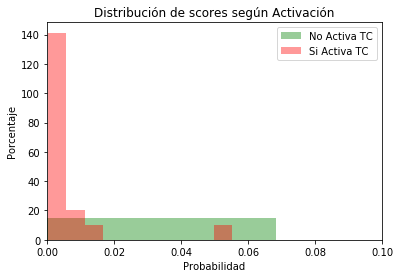

In [311]:
# Graficar probabilidades según Fraude/No Fraude observado (real)

subset_si = mdt_test[y_test == 1]

subset_no = mdt_test[y_test == 0]

sns.distplot(subset_no[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'No Activa TC', color = 'green')

sns.distplot(subset_si[['probs']], hist = True, norm_hist = True, bins = 10, kde = False, kde_kws = {'linewidth' : 3},
            label = 'Si Activa TC', color = 'red')

plt.legend(prop = {'size' : 10})
plt.title('Distribución de scores según Activación')
plt.xlabel('Probabilidad')
plt.ylabel('Porcentaje')
plt.xlim([0.0,0.1])
plt.show()

/home/jupyter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


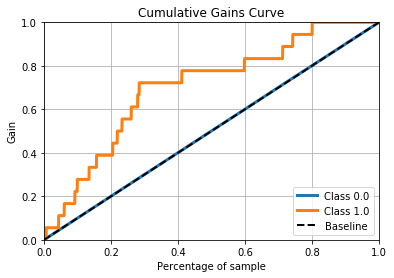

In [279]:
skplt.metrics.plot_cumulative_gain(y_test, probs_test)

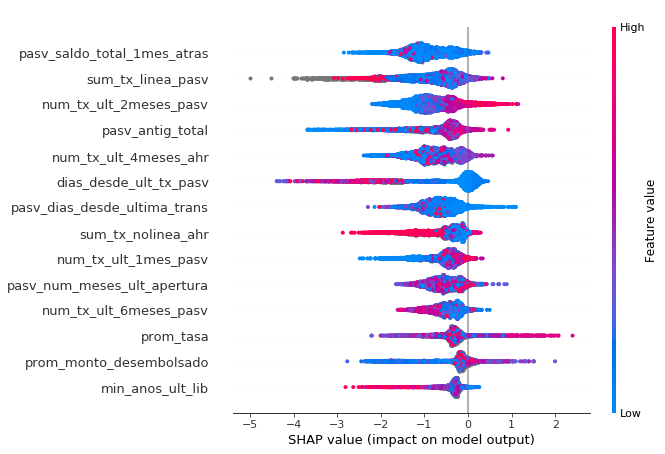

In [280]:
shap_values = shap.TreeExplainer(xgb_model_v2).shap_values(mdt_test[best_60])
shap.summary_plot(shap_values, mdt_test[best_60])

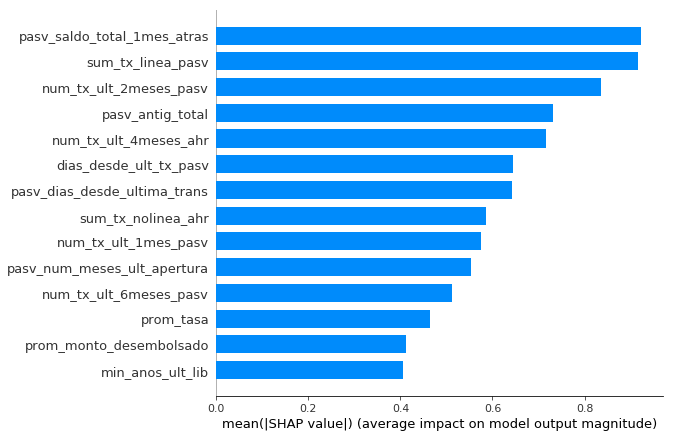

In [281]:
shap.summary_plot(shap_values, mdt_test[best_60], plot_type = 'bar')

In [312]:
# ## Guardando modelo
# import pickle

# fecha = '20200623' # definir fecha
# MODELO = xgb_model_v2
# xgboost_filename = '/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/Modelos PKL/Model_perf_'+fecha+'_VFinal.pkl'
# xgboost_pkl = open(xgboost_filename, 'wb')
# pickle.dump(MODELO, xgboost_pkl)
# xgboost_pkl.close()

In [ ]:
# ## Creando bases para guardar
# train = X_train.join(y_train, how='left')
# val = X_val.join(y_val, how='left')
# test = mdt_test.join(y_test, how='left')

In [ ]:
# # Guardando bases:
# train.reset_index().to_csv('/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/Bases Train_val_test/Perfilados/trainV0.csv', sep="|", encoding='utf-8', index=False)
# val.reset_index().to_csv('/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/Bases Train_val_test/Perfilados/validationV0.csv', sep="|", encoding='utf-8', index=False)
# test.reset_index().to_csv('/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/Bases Train_val_test/Perfilados/testV0.csv', sep="|", encoding='utf-8', index=False)


In [336]:
total = pd.concat([train,val,test],ignore_index=False)
print(total.shape)
total.reset_index().to_csv('/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/Bases Train_val_test/Perfilados/totalV0.csv', sep="|", encoding='utf-8', index=False)

(21643, 142)


## Tablas validación

In [315]:
## tablas validación test
test['probs'] = xgb_model_v2.predict_proba(test[best_60])[:, 1]
test['decil_ModV0']=pd.qcut(test['probs'].rank(method='first'),5, labels=False)
pd.crosstab(test['decil_ModV0'],test['venta'], margins=False)

venta,0.0,1.0
decil_ModV0,,
0,1296,1
1,1295,2
2,1294,2
3,1291,6
4,1290,7


In [320]:
test.groupby('decil_ModV0')[['probs']].min()

,probs
decil_ModV0,
0,0.000043
1,0.000159
2,0.000282
3,0.000637
4,0.001889


In [321]:
test.groupby('decil_ModV0')[['probs']].max()

,probs
decil_ModV0,
0,0.000159
1,0.000282
2,0.000636
3,0.001883
4,0.682260


In [316]:
#Tabla validacion Train
train['probs'] =  xgb_model_v2.predict_proba(train[best_60])[:, 1]
train['decil_ModV0']=pd.qcut(train['probs'].rank(method='first'),5, labels=False)
pd.crosstab(train['decil_ModV0'],train['venta'], margins=False)

venta,0.0,1.0
decil_ModV0,,
0,2134,0
1,2133,0
2,2133,0
3,2133,0
4,2101,32


In [327]:
train.groupby('decil_ModV0')[['probs']].min()

,probs
decil_ModV0,
0,0.000033
1,0.000156
2,0.000279
3,0.000614
4,0.001880


In [323]:
train.groupby('decil_ModV0')[['probs']].max()

,probs
decil_ModV0,
0,0.000156
1,0.000279
2,0.000614
3,0.001878
4,0.999476


In [354]:
#Tabla validacion Total
total['probs'] =  xgb_model_v2.predict_proba(total[best_60])[:, 1]
total['decil_ModV0']=pd.qcut(total['probs'].rank(method='first'),5, labels=False)
pd.crosstab(total['decil_ModV0'],total['venta'], margins=False)

venta,0.0,1.0
decil_ModV0,,
0,4326,3
1,4325,3
2,4324,5
3,4318,10
4,4288,41


In [355]:
total.groupby('decil_ModV0')[['probs']].min()

,probs
decil_ModV0,
0,0.000029
1,0.000158
2,0.000273
3,0.000542
4,0.001588


In [356]:
total.groupby('decil_ModV0')[['probs']].max()

,probs
decil_ModV0,
0,0.000158
1,0.000273
2,0.000542
3,0.001587
4,0.999424


In [324]:
## Comparando volumen
test['probs'] = xgb_model_v2.predict_proba(test[best_60])[:, 1]
test['decil_33']=pd.qcut(test['probs'].rank(method='first'),3, labels=False)
pd.crosstab(test['decil_33'],test['venta'], margins=False)

venta,0.0,1.0
decil_33,,
0,2159,3
1,2159,2
2,2148,13


In [325]:
test.groupby('decil_33')[['probs']].min()

,probs
decil_33,
0,0.000043
1,0.000225
2,0.000886


In [326]:
test.groupby('decil_33')[['probs']].max()

,probs
decil_33,
0,0.000225
1,0.000885
2,0.682260


In [328]:
test['rangos'] = np.where(test['probs']< 0.001,3,
                       np.where(test['probs']< 0.0025,2,1))

ab = pd.crosstab(test['rangos'],test['venta']).sort_index(ascending=False)
ab.columns = ['buenos', 'malos']
ab['total'] = ab.sum(axis=1)
ab['tasa m'] = ab['malos']/ab['total']
ab

,buenos,malos,total,tasa m
rangos,,,,
3,4474,5,4479,0.001116
2,919,6,925,0.006486
1,1073,7,1080,0.006481


In [342]:
### Estabilidad
mdt['probs'] = xgb_model_v2.predict_proba(mdt[best_60])[:, 1]
mdt['decil_mod']=pd.qcut(mdt['probs'].rank(method='first'),9, labels=False)

pd.crosstab(mdt['decil_mod'],mdt['mes_campaña'])

mes_campaña,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
decil_mod,,,,,,,,,,,
0,402,338,305,445,391,81,243,195,193,131,358
1,562,414,353,501,269,56,266,238,186,60,176
2,244,146,260,205,220,219,565,445,406,158,213
3,316,139,193,254,377,200,364,335,368,231,304
4,279,211,252,334,346,248,270,275,340,274,252
5,211,219,305,292,287,284,330,264,352,323,214
6,140,252,351,274,163,336,382,303,334,326,220
7,118,343,336,298,148,368,393,307,289,296,185
8,61,577,315,313,77,380,420,260,262,254,163


## Cross Validation

In [329]:
##Poner el nombre del modelo que se quiere usar para la validacion cruzada
MODELO=xgb_model_v2
##Base que contiene las variables explicativa y variable respuesta
X=train[best_60]
Y=train['venta']

In [337]:
######### KFolds Cross Validation
##Se estima el modelo en muestras (folds) para revisar overfit y estabilidad
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


def kfold_crossval(df,label,n_splits,model,cut,output_name,output_path):
    OUTPUT_PATH=output_path
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=True)
    i=0
    metrics_kfold = pd.DataFrame(columns = ['auc', 'accuracy', 'recall'])
    for train, test in kfold.split(df,label):

        probas = model.predict_proba(df.iloc[test])
    
        roc_auc_kfold = metrics.roc_auc_score(label.iloc[test], probas[:, 1])

        fpr, tpr, thresholds = metrics.roc_curve(
                label.iloc[test],
                probas[:, 1], pos_label=1
                )
    
        y_pred=(probas[:,1]>cut).astype(int)
    
        metrics_kfold.loc[i]=[metrics.auc(fpr, tpr), metrics.accuracy_score(label.iloc[test], y_pred), metrics.recall_score(label.iloc[test],y_pred)]
        i=i+1
        name=output_name
    metrics_kfold.to_csv(OUTPUT_PATH + name,
                   header=True,
                   index=False)  
    return metrics_kfold
    

In [338]:
d = kfold_crossval(X,Y,10,MODELO,0.000885,'metrics_kfold',"/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/")
d

,auc,accuracy,recall
0,0.967732,0.735708,1.000000
1,1.000000,0.716026,1.000000
2,0.854950,0.720712,0.666667
3,1.000000,0.719775,1.000000
4,1.000000,0.737582,1.000000
5,1.000000,0.709466,1.000000
6,0.902164,0.695122,1.000000
7,1.000000,0.714822,1.000000
8,0.999373,0.706379,1.000000
9,1.000000,0.712008,1.000000


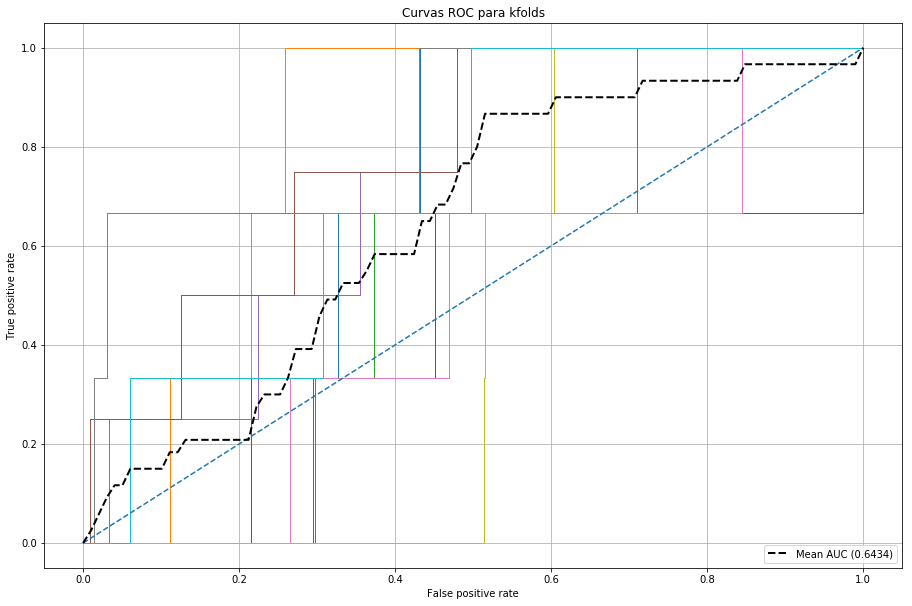

In [339]:
##Grafico curva ROC para los k folds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# %%
    
def plot_ROC_kfolds(classifier, x_train, y_train, kfold, title):
    '''
    Plots ROC curves for all kfolds and the calculates the average.
    '''

    mean_fpr = np.linspace(0, 1, 100)

    fig = plt.figure(figsize=(6*2.13, 4*2.13))

    tprs = []
    threaucs = []

    for train, test in kfold.split(x_train, y_train):

        probas = classifier.fit(
                x_train.iloc[train, :], y_train.iloc[train]).predict_proba(
                        x_train.iloc[test, :]
                        )

        fpr, tpr, thresholds = metrics.roc_curve(
                y_train.iloc[test],
                probas[:, 1], pos_label=1
                )

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc=metrics.auc(fpr, tpr)
        threaucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1)

    plt.plot([0, 1], [0, 1], linestyle='--')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)

    plt.plot(
            mean_fpr,
            mean_tpr,
            'k--',
            label='Mean AUC (%0.4f)' % mean_auc,
            lw=2
            )

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend(loc=4)
    plt.grid()
    fig.tight_layout()

# %%

######### ROC curve for several kfolds
    
title = 'Validación Cruzada - Curva ROC'
#seed = 123
train_sizes = np.linspace(.2, 1.0, 10)

# Define cross validation with 5 folds
kfold = StratifiedKFold(n_splits=10,shuffle=True)

# Plotting ROC curve for several kfolds
plot_ROC_kfolds(
            MODELO,
            X,
            Y,
            kfold,
            'Curvas ROC para kfolds'
            )

# %%

In [83]:
## Correr arbol
#main(X_train,y_train)


In [84]:
# Testing tree
my_tree(X_test)

NameError: name 'my_tree' is not defined

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))